# DataJoint U24 - Workflow DeepLabCut

## Setup

The notebook requires DeepLabCut pose estimation already processed via DataJoint.

- If you don't have data, refer to [00-DataDownload](./00-DataDownload_Optional.ipynb) and [01-Configure](./01-Configure.ipynb).
- For an overview of the schema, refer to [02-WorkflowStructure](02-WorkflowStructure_Optional.ipynb).
- For step-by-step or autmated ingestion, refer to [03-Process](./03-Process.ipynb) or [03-Automate](03-Automate_Optional.ipynb).

Let's change the directory to load the local config, `dj_local_conf.json` and import the relevant schema.

In [1]:
import os # change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='workflow-deeplabcut', ("Please move to the "
                                                              + "workflow directory")

import datajoint as dj # Import relevant schema
from workflow_deeplabcut.pipeline import model

# Directing our pipeline to the appropriate config location
from element_interface.utils import find_full_path
from workflow_deeplabcut.paths import get_dlc_root_data_dir
config_path = find_full_path(get_dlc_root_data_dir(), 
                             'from_top_tracking/config.yaml')

# Grabbing the relevant key
import pandas as pd
key = (model.PoseEstimation & "recording_id=1").fetch('KEY')

Connecting cbroz@dss-db.datajoint.io:3306


## Fetching data

In the previous notebook, we saw how to fetch data as a pandas dataframe.

In [192]:
df=model.PoseEstimation.get_trajectory(key)
df_xy = df.iloc[:,df.columns.get_level_values(2).isin(["x","y"])]['FromTop-latest']
df_xy.mean()

bodyparts   coords
bodycenter  x         231.709213
            y         351.878936
head        x         234.893540
            y         367.393746
tailbase    x         235.567368
            y         333.615991
dtype: float64

## Plotting

We plot these coordinates over time. 

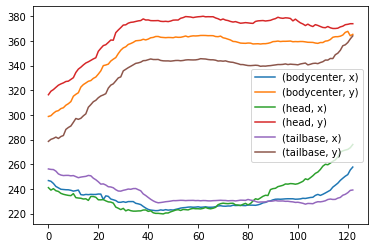

In [103]:
df_xy.plot().legend(loc='right')

Next, we'll make a copy of the data for the next plot.

In [ ]:
df_flat = df_xy.copy()
df_flat.columns = df_flat.columns.map('_'.join)

Here, we can overlay the traces of each point over time.

<AxesSubplot:xlabel='tailbase_x'>

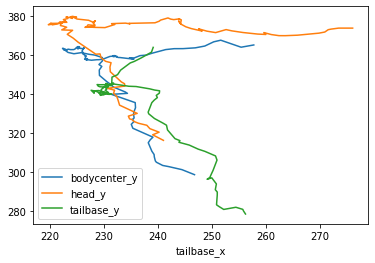

In [196]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots()
df_flat.plot(x='bodycenter_x',y='bodycenter_y',ax=ax)
df_flat.plot(x='head_x',y='head_y', ax=ax)
df_flat.plot(x='tailbase_x',y='tailbase_y', ax=ax)

Our visual check shows that these trajectories are more-or-less aligned.

## Video Labeling

This Element adds to the DeepLabCut tree structure by sorting results files into output directories. Let's see where they're stored using `infer_output_dir`.

In [199]:
destfolder = model.PoseEstimationTask.infer_output_dir(key)
destfolder

PosixPath('/tmp/test_data/from_top_tracking/videos/device_Camera1_recording_1_model_FromTop-latest')

When labeling videos, we need to provide this as an additional argument. 

Note that DataJoint handles paths as `pathlib` objects, while DeepLabCut requires strings.

In [200]:
from deeplabcut.utils.make_labeled_video import create_labeled_video

video_path = find_full_path( # Fetch the full video path
    get_dlc_root_data_dir(), ((model.VideoRecording.File & key).fetch1("file_path"))
)

config_paths = sorted( # Of configs in the project path, defer to the datajoint-saved
    list(
        find_full_path(
            get_dlc_root_data_dir(), ((model.Model & key).fetch1("project_path"))
        ).glob("*.y*ml")
    )
)

create_labeled_video( # Pass strings to label the video
    config=str(config_paths[-1]),
    videos=str(video_path),
    destfolder=str(destfolder),
)


Loading DLC 2.2.1.1...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)
Loading DLC 2.2.1.1...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)
Starting to process video: /tmp/test_data/from_top_tracking/videos/test-2s.mp4
Loading /tmp/test_data/from_top_tracking/videos/test-2s.mp4 and data.
Duration of video [s]: 2.05, recorded with 60.0 fps!
Overall # of frames: 123 with cropped frame dimensions: 500 500
Generating frames and creating video.


100%|██████████| 123/123 [00:00<00:00, 236.95it/s]


The video should now be labeled at this path

In [206]:
from IPython.display import FileLink
FileLink(path=video_path)

/tmp/test_data/from_top_tracking/videos/test-2s.mp4

In the next notebook, [06-Drop](./06-Drop_Optional.ipynb), we'll demonstrate dropping schemas in this Element.